# Emotional Sentiment on Twitter
## A coronavirus vaccine online firestorm

<img src="../images/Average_sentiment_during_onlinestorm.png">

The ongoing competition for a viable vaccine against coronavirus is arguably the race of the century. With its hundred millions of users, Twitter is particularly well-suited for research into sentiment and emotions running in social media. 

This is how it all begun: an exercise of 'real politiks' that is likely to change dramatically the way science, politics and business colide in a pos-covid19 world. As we will see below, the 15th March 2020 will go down in history as a shift of political tone that is at odds with the collaborative, responsible and ethical behaviour of scientific research.

I collected the data scraping tweets from Twitter’s application program inter-face (API), using TwitterScraping. Tweets were saved on a daily basis using the fol-lowing search term “Curevac”, the name of a German vaccine maker backed by Bill & Melinda Gates Foundation, and currently working on a Covid-19 vaccine. The post covers tweets from a 6-year period from March 3, 2014 to March 18, 2020 (N = 14,991).

The post covers tweets from a 6-year period from March 3, 2014 to March 18, 2020.

Results include 15,036 tweets in a wide range of languages. 

In this notebook you will find examples of some of the most common NLP (Natural Language Processing) techniques used to uncover patterns of sentiment and emotion in the kind of unstructured data that is predominant in Twitter. It is organized as follows:

- Step 1: Exploratory analysis
- Step 2: Text processing
- Step 3: Sentiment analysis
- Step 4: LDA topics extraction
- Step 5: Emotion analysis


## Step 1:  EXPLORATORY ANALYSIS

After scrapping the Twitter API, the retained tweets were gathered in an excel file (tweets_curevac.xlsx).

Below we have the major Python packages that are required for data handling (pandas), scientific computing (numpy) and data visualization (matplotlib and seaborn).

In [94]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [95]:
from collections import defaultdict
from datetime import date

import re # for regular expressions
import string

In [96]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Importing the data

In [102]:
tweets = pd.read_csv('../input/tweets.csv')

In [106]:
# getting the date column ready for datetime operations
tweets['datetime']= pd.to_datetime(tweets['datetime'])

Here is a view of the first rows:

In [107]:
tweets.head()

,datetime,text
0,2014-03-12 18:26:59,Robert-Jan Smits at Innovation Convention 2014...
1,2014-03-13 09:50:54,First #EU #vaccine prize awarded 2 CureVac ...
2,2014-03-14 12:50:28,Congrats 2 CureVac ! 4 #EU #vaccine prize #...
3,2014-03-14 16:01:30,MT @sanofiDE CureVac Wins Two Million EUR f...
4,2014-03-14 17:44:32,CureVac wins EU's EUR2m inducement prize for ...


And here is a plot of the tweets with thw word "CureVac" over the past 6 years.

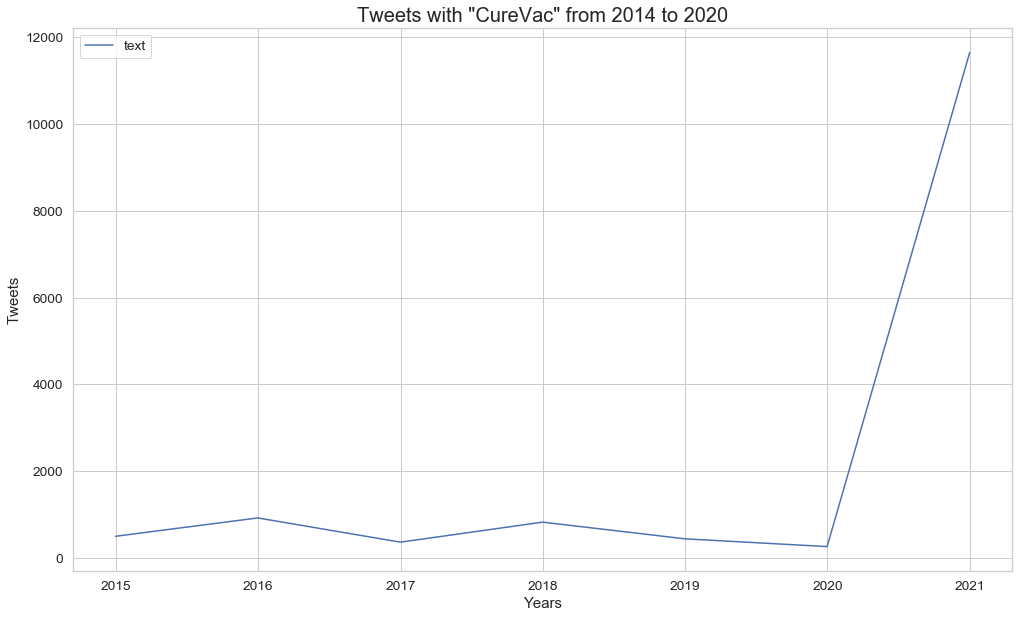

In [108]:
# A simple timeseries plot
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=tweets.set_index("datetime").groupby(pd.Grouper(freq='Y')).count())
plt.title('Tweets with "CureVac" from 2014 to 2020', fontsize=20)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Tweets', fontsize=15)
fig.savefig("../images/All_Tweets_2014-2020.png")

For several years, the rate of tweets went on at a regular pace, until one day ... everything changed!

Digital marketing researchers call these events “online firestorms”, referring to negative word of mouth (eWOM) that suddenly attract thousands of expres-sions of support from other clients through social [1].

<img src="../images/fig01_washingtonpost.png">

Let us create a column to identify this three-days event.


In [109]:
# creating a column to filter the onlinestorm (from 15 and 18 March)
def make_onlinestorm_field():
    for i, row in tweets.iterrows():
        if pd.to_datetime(tweets.at[i, 'datetime']) > pd.Timestamp(date(2020,3,15)):
            tweets.at[i, 'onlinestorm'] = True
        else:
            tweets.at[i, 'onlinestorm'] = False  
            
make_onlinestorm_field()

In [110]:
# count tweets during the three days online storm
print('In three days, tweets went over {}, all around the world.'.format(tweets[tweets['onlinestorm']]['onlinestorm'].count()))

In three days, tweets went over 11364, all around the world.


Here we have them ..

In [111]:
tweets[tweets['onlinestorm']]

,datetime,text,onlinestorm
3627,2020-03-15 00:07:55,Germany's CureVac says low-dose coronavirus ...,True
3628,2020-03-15 00:14:42,ドイツのディ・ヴェルト紙（ネット版、3月15日）が伝えるところによると、米国政府がドイツでコ...,True
3629,2020-03-15 00:18:05,Germany's CureVac says low-dose coronavirus ...,True
3630,2020-03-15 00:30:29,"A Bill & Melinda Gates funded, German Biotech ...",True
3631,2020-03-15 00:42:51,.@BillGates .@gatesfoundation .@melindagates...,True
...,...,...,...
14986,2020-03-18 13:33:33,CureVac -Miteigentümer: Hopp macht Hoffnung au...,True
14987,2020-03-18 13:33:36,"Non, c'était dans la presse allemande. L'actio...",True
14988,2020-03-18 13:35:22,Rainer Hachfeld https:// cartoonmovement.sho...,True
14989,2020-03-18 13:36:14,ドイツのバイオテクノロジー企業である CureVac が新型コロナのワクチンを秋までに開発す...,True


Let's have a look at the distribution of the tweets by the hour during the online storm.

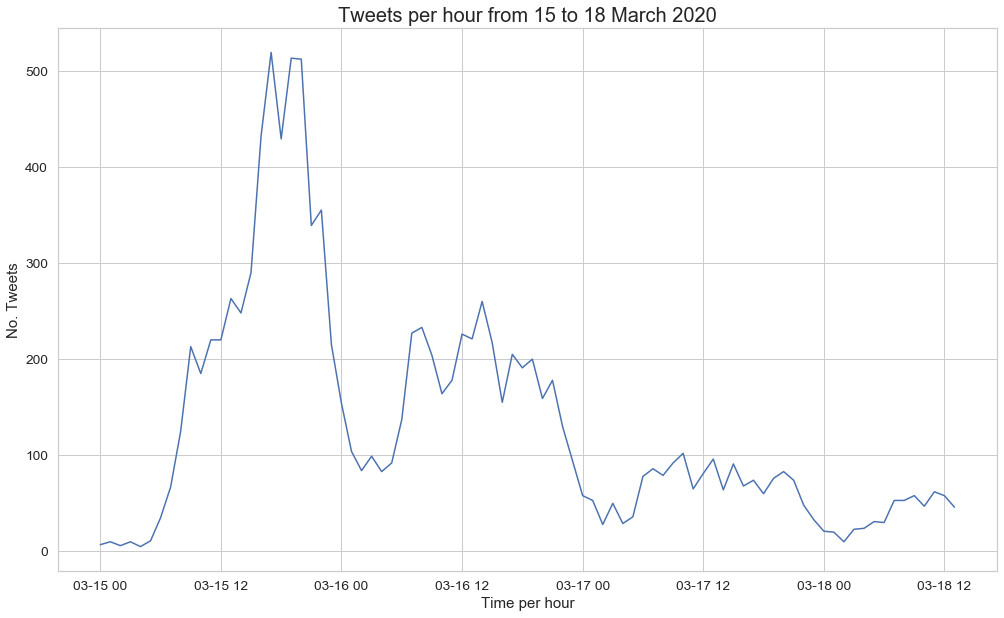

In [112]:
# plot it
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=tweets[tweets['onlinestorm'] == True].set_index("datetime").groupby(pd.Grouper(freq='H')).onlinestorm.count())
plt.title('Tweets per hour from 15 to 18 March 2020', fontsize=20)
plt.xlabel('Time per hour', fontsize=15)
plt.ylabel('No. Tweets', fontsize=15)
fig.savefig("../images/All_Tweets_Onlinestorm.png")

It is time to have a first look at the content of the tweets and do some descriptive statistics. For now, I will focus only on features like hastags, mentions, urls, capital words and words in general.

In [113]:
# A function to count tweets based on regular expressions
def count_tweets(reg_expression, tweet):
    tweets_list = re.findall(reg_expression, tweet)
    return len(tweets_list)

In [114]:
# Creating a dictionary to hold the counts
content_count = {
    'words' : tweets['text'].apply(lambda x: count_tweets(r'\w+', x)),
    'mentions' : tweets['text'].apply(lambda x: count_tweets(r'@\w+', x)),
    'hashtags' : tweets['text'].apply(lambda x: count_tweets(r'#\w+', x)),
    'urls' : tweets['text'].apply(lambda x: count_tweets(r'http.?://[^\s]+[\s]?', x)),   
}

In [115]:
df = pd.concat([tweets, pd.DataFrame(content_count)], axis=1);df

,datetime,text,onlinestorm,words,mentions,hashtags,urls
0,2014-03-12 18:26:59,Robert-Jan Smits at Innovation Convention 2014...,False,26,1,0,1
1,2014-03-13 09:50:54,First #EU #vaccine prize awarded 2 CureVac ...,False,23,0,4,0
2,2014-03-14 12:50:28,Congrats 2 CureVac ! 4 #EU #vaccine prize #...,False,21,0,5,0
3,2014-03-14 16:01:30,MT @sanofiDE CureVac Wins Two Million EUR f...,False,17,1,0,0
4,2014-03-14 17:44:32,CureVac wins EU's EUR2m inducement prize for ...,False,33,0,2,1
...,...,...,...,...,...,...,...
14986,2020-03-18 13:33:33,CureVac -Miteigentümer: Hopp macht Hoffnung au...,True,18,0,0,0
14987,2020-03-18 13:33:36,"Non, c'était dans la presse allemande. L'actio...",True,46,0,0,1
14988,2020-03-18 13:35:22,Rainer Hachfeld https:// cartoonmovement.sho...,True,42,4,2,0
14989,2020-03-18 13:36:14,ドイツのバイオテクノロジー企業である CureVac が新型コロナのワクチンを秋までに開発す...,True,39,0,0,1


### Tweets descriptive statistics

In [116]:
# Display some descriptive statistics  
for key in content_count.keys():
    print()
    print('Descriptive statistics for {}'.format(key))
    print(df.groupby('onlinestorm')[key].describe())


Descriptive statistics for words
               count       mean        std  min   25%   50%   75%    max
onlinestorm                                                             
False         3627.0  23.355390  10.731606  3.0  16.0  20.0  29.0  113.0
True         11364.0  34.571718  15.048733  1.0  23.0  36.0  45.0  147.0

Descriptive statistics for mentions
               count      mean       std  min  25%  50%  75%   max
onlinestorm                                                       
False         3627.0  0.304659  0.931811  0.0  0.0  0.0  0.0  12.0
True         11364.0  0.205297  0.694837  0.0  0.0  0.0  0.0  14.0

Descriptive statistics for hashtags
               count      mean       std  min  25%  50%  75%   max
onlinestorm                                                       
False         3627.0  0.971602  1.611123  0.0  0.0  0.0  2.0  13.0
True         11364.0  1.071454  1.923787  0.0  0.0  0.0  1.0  19.0

Descriptive statistics for urls
               count      mean 

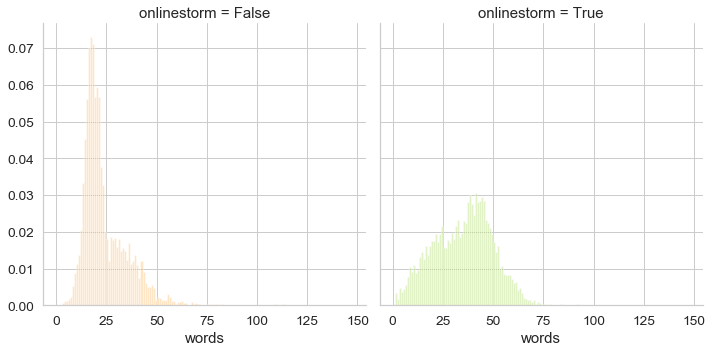

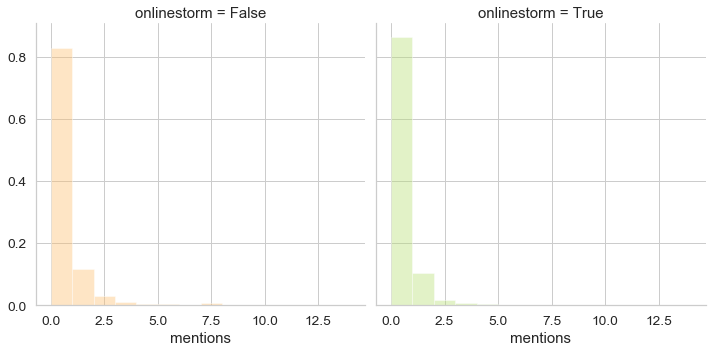

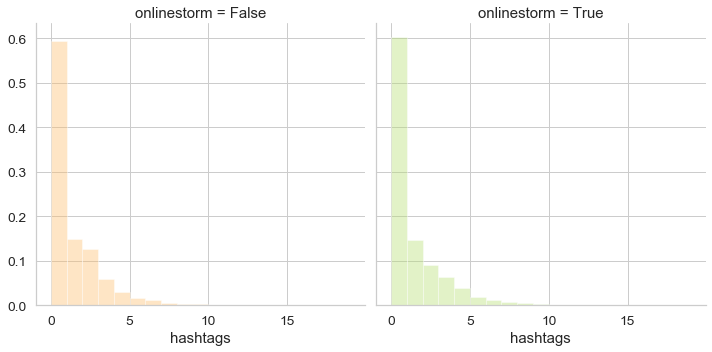

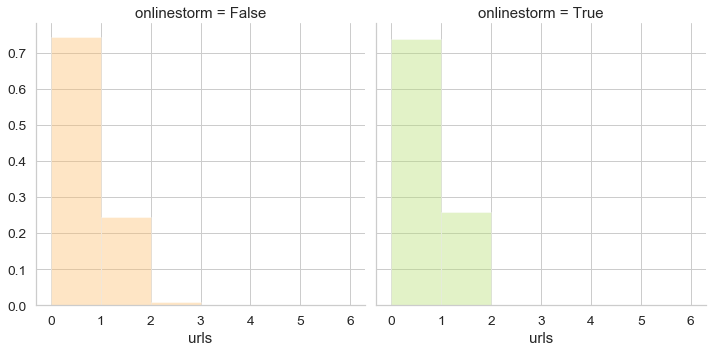

In [117]:
# Now plot them 
for key in content_count.keys():

    bins = np.arange(df[key].min(), df[key].max() + 1)
    g = sns.FacetGrid(df, col='onlinestorm', height=5, hue='onlinestorm', palette="RdYlGn")
    g = g.map(sns.distplot, key, kde=False, norm_hist=True, bins=bins)
    plt.savefig('../images/Descriptive_stats_for_' + key + '.png')

From the above descriptive statistics, there are no noteworthy differences in terms of mentions, hashtags or urls during the online storm.
Yet, the average number of words, per tweet, increased substantially during this period.


## Step 2: TEXT PROCESSING

For the next steps, I retained only the tweets in English, avoiding duplicates. These are contained in an excel file ('Tweets_CureVac_en.xlsx') with 6,546 tweets.

The second step of our analysis will look deeper into the content of these tweets. It is time to apply some of the basic NLP operations, such as cleaning, tokenizing and lemmatizing.

We will use NLTK (Natural Language Toolkit), one of the most popular NLP libraries fo Python.

In [118]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

In [119]:
import string
import re
from collections import Counter    # Look at the most common item in a list

In [120]:
# I am adding my own stopwords list to the NLTK list.
# This way we can drop words that are not relevant to the text processing
MY_STOPWORDS = ['curevac','vaccine','german','mrna','biotech','cancer','lilly','eli','ag','etherna_immuno', 'translatebio', 'mooreorless62','boehringer', 'ingelheim','biopharmaceutical', 'company']
STOPLIST = set(stopwords.words('english') + list(MY_STOPWORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "``", ",", ".", ":", "''","#","@"]

In [121]:
# The NLTK lemmatizer and stemmer classes
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [128]:
# read english selected tweets, no duplicates
tweets = pd.read_csv('../input/tweets_en.csv')

In [129]:
# I use the POS tagging from NLTK to retain only adjectives, verbs, adverbs and nouns for lemmatization.
def get_lemmas(tweet): 
    
    # A dictionary to help convert Treebank tags to WordNet
    treebank2wordnet = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    
    postag = ''
    lemmas_list = []
    
    for word, tag in pos_tag(word_tokenize(tweet)):
        if tag.startswith("JJ")     \
            or tag.startswith("RB") \
            or tag.startswith("VB") \
            or tag.startswith("NN"):
                
            try:
                postag = treebank2wordnet[tag[:2]]
            except:
                postag = 'n'                
                            
            lemmas_list.append(lemmatizer.lemmatize(word.lower(), postag))    
    
    return lemmas_list

In [130]:
# This function processes, cleans and filters the tokens for each tweet
def clean_tweet(tokens):
    
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in STOPLIST:
                if token[0] not in SYMBOLS:
                    if not token.startswith('http'):
                        if  '/' not in token:
                            if  '-' not in token:
                                filtered.append(token)
                                        
    return filtered

In [131]:
# Starts the lemmatization process
def get_lemmatized(tweet):
   
    all_tokens_string = ''
    filtered = []
    tokens = []

    # lemmatize
    tokens = [token for token in get_lemmas(tweet)]
    
    # filter
    filtered = clean_tweet(tokens)

    all_tokens_string = ' '.join(filtered)
    
    return all_tokens_string

In [132]:
# get the lemmatized tweets and puts the result in an "edited" text column for future use
edited = ''
for i, row in tweets.iterrows():
    edited = get_lemmatized(tweets.loc[i]['text'])
    if len(edited) > 0:
        tweets.at[i,'edited'] = edited
    else:
        tweets.at[i,'edited'] = None        

In [133]:
# After lemmatization, some tweets may have as a result the same words
# Let's make sure that we have no duplicates
tweets.drop_duplicates(subset=['edited'], inplace=True)
tweets.dropna(inplace=True)


Here is the result of our pre-processing, showing the difference between the original tweet (column "text") and the lemmatized, clean, tweet (column "edited")

In [134]:
tweets.head()

,datetime,text,edited
0,2020-03-16 11:13:00,"Interior Minister Horst Seehofer, when asked t...",interior minister horst seehofer ask confirm r...
1,2020-03-16 03:34:02,CureVac said it has been in contact with many...,say contact many organization global authority...
2,2015-07-07 13:24:10,CureVac Announces Phase I/IIa Clinical Study ...,announces phase clinical study data immunother...
3,2015-11-02 13:21:08,CureVac alone has received >$100M from US fou...,alone receive us foundation gate darpa manufac...
4,2020-03-16 20:10:33,I hope to God CureVac doesn't cave. Trump is...,hope god n't cave trump despicable po planet


## Step 3: SENTIMENT ANALYSIS

For sentiment analysis -- a growing sub-field of Natural Language Processing (NLP) -- I used VADER (Valence Aware Dictionary for Sentiment Reasoning), a rule-based system that performs specially well on social media data. 

VADER quantifies the sentiment of a tweet based on positive, neutral and neg-ative scores, and uses a Compound score to account for the intensity of the overall sentiment of a given text. It measures the strength of sentiments by giving scores ranging from +1 to -1 with positive numbers indicate favorable atti-tudes while negative numbers indicate negative attitudes. 

In this section, I will focus on a simple comparison between the sentiment (Compound score) of  a 6-year period with the score over the three days of the CureVac online firestorm, from March 15 to March 18.

Let us import the VADER analyser.

In [135]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


For the puropose of the timeseries analysis, we must make sure that the tweets are all correctly sorted.

In [136]:
tweets['datetime']=pd.to_datetime(tweets['datetime']) 
tweets.sort_values('datetime', inplace=True, ascending=True)
tweets = tweets.reset_index(drop=True)

In [137]:
# creating a column to "filter" the online storm period.
make_onlinestorm_field()


In [138]:
def plot_sentiment_period(df, info):
    
    df1 = df.groupby(df['datetime'].dt.to_period(info['period'])).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, info['cols'])

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3, dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(info['title'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=15)
    plt.ylabel(info['ylab'], fontsize=15)
    plt.tight_layout()
    plt.savefig('../images/' + info['fname'])    
    return

In [139]:
def plot_frequency_chart(info):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data'], palette=(info['pal']))
    ax.set_title(label=info['title'], fontweight='bold', size=18)
    plt.ylabel(info['ylab'], fontsize=16)
    plt.xlabel(info['xlab'], fontsize=16)
    plt.xticks(rotation=info['angle'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('../images/' + info['fname'])
    
    return

In [140]:
# Calling VADER
analyzer = SentimentIntensityAnalyzer()

In [141]:
# get VADER Compound value for sentiment intensity
tweets['sentiment_intensity'] = [analyzer.polarity_scores(v)['compound'] for v in tweets['edited']]

The output of VADER are the positive, negative, and neutral ratios of sentiment. The most useful metric is the compound score, which is computed by summing the valence scores of each word in the lexicon, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This can be considered a ‘normalized, weighted composite score’.

The threshold values for the compound score are as follows:

* Positive sentiment : (compound score >= 0.05).

* Neutral sentiment : (compound score > -0.05) and (compound score < 0.05).

* Negative sentiment : (compound score <= -0.05)



In [142]:
def get_sentiment(intensity):
    if intensity >= 0.05:
        return 'Positive'
    elif (intensity >= -0.05) and (intensity < 0.05):
        return 'Neutral'
    else:
        return 'Negative'
        
tweets['sentiment'] = tweets.apply(lambda x: get_sentiment(x['sentiment_intensity']),axis=1)

## The Online Storm

 The next plot gives us a clear image of the “explosion” of contradictory sentiments in this period:

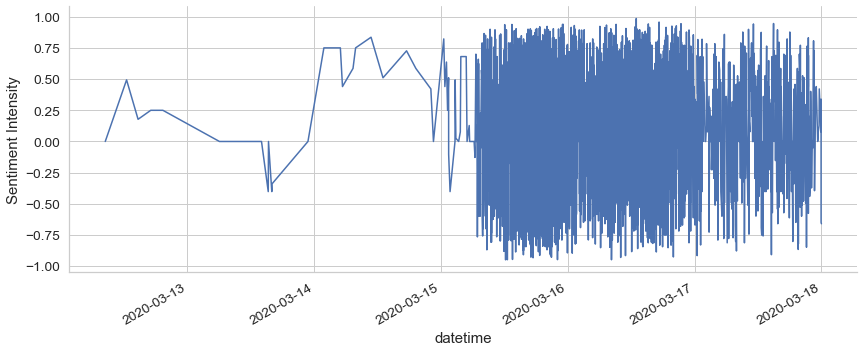

In [143]:
df=tweets.loc[:,['datetime','sentiment_intensity']]
df.set_index('datetime',inplace=True)
df=df[(df.index>='2020-03-12') & (df.index<'2020-03-18')]
df.plot(figsize=(12,5));
plt.ylabel('Sentiment Intensity')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.savefig('../images/Average_sentiment_during_onlinestorm.png')   
plt.show();

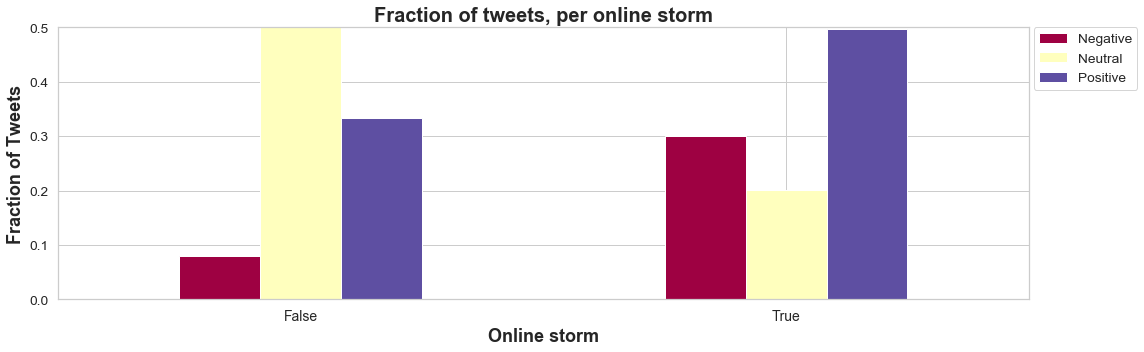

In [144]:
props = tweets.groupby('onlinestorm')['sentiment'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Online storm', fontweight='bold', fontsize=18)
plt.xticks(rotation=0,fontsize=14)
plt.ylim(0, 0.5)
plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
plt1.set_title(label='Fraction of tweets, per online storm', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('../images/percentage_tweets_vs_online_storm.png')

## Step 4: Word Frequency

In [145]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [146]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [147]:
from matplotlib.colors import makeMappingArray
from palettable.colorbrewer.diverging import Spectral_4

### Some basic word statistics 

In [148]:
tweets['word_count'] = tweets.apply(lambda x: len(x['text'].split()),axis=1)
t = pd.DataFrame(tweets['word_count'].describe()).T
t

,count,mean,std,min,25%,50%,75%,max
word_count,5508.0,30.546659,12.499944,4.0,19.0,31.0,42.0,61.0


In [149]:
def plot_frequency_chart(info):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data'], palette=(info['pal']))
    ax.set_title(label=info['title'], fontweight='bold', size=18)
    plt.ylabel(info['ylab'], fontsize=16)
    plt.xlabel(info['xlab'], fontsize=16)
    plt.xticks(rotation=info['angle'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('../images/' + info['fname'])
    
    return

In [150]:
def display_wordcloud(tokens):
    
    tokens_upper = [token.upper() for token in tokens]

    cloud_mask = np.array(Image.open("../images/cloud_mask.png"))
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=50, width=2500, 
                          height=1750,mask=cloud_mask, 
                          background_color="white").generate(" ".join(tokens_upper))
    plt.figure()
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    return

In [151]:
def get_trigrams(trigrams, top_grams):
    
    grams_str = []
    data = []

    gram_counter = Counter(trigrams)
    
    for grams in gram_counter.most_common(10):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)

    df = pd.DataFrame(data, columns = ['Grams', 'Count'])

    return df

In [152]:
# Susan Li's predefined functions

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, n_topics, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(", ".join(topic_words))         
    return top_words

In [153]:
# LDA topics
def get_topics(edited, n_topics, n_words):

    eds = edited.values
    
    vec = TfidfVectorizer(use_idf=True, smooth_idf=True)
    document_term_matrix = vec.fit_transform(eds)
    
    model = LatentDirichletAllocation(n_components=n_topics)
    topic_matrix = model.fit_transform(document_term_matrix)
    
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(n_words, n_topics, keys, document_term_matrix, vec)

    topics = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    data=[]
    for i, topic in enumerate(topics):
        tmp = []
        tmp.append(topic)
        tmp.append(counts[i])
        data.append(tmp)
    df_topics = pd.DataFrame(data, columns = ['Topics', 'Count'])
    
    return df_topics

## Before the online storm

In [154]:
df = tweets[tweets['onlinestorm'] == False]

In [155]:
# Merging all the requests into a single line
text_merged = ''
for line in df['edited']:
    text_merged = text_merged + ' ' + line
    
# get tokens and trigrams
tokens = text_merged.split(' ')
trigrams = nltk.trigrams(tokens)

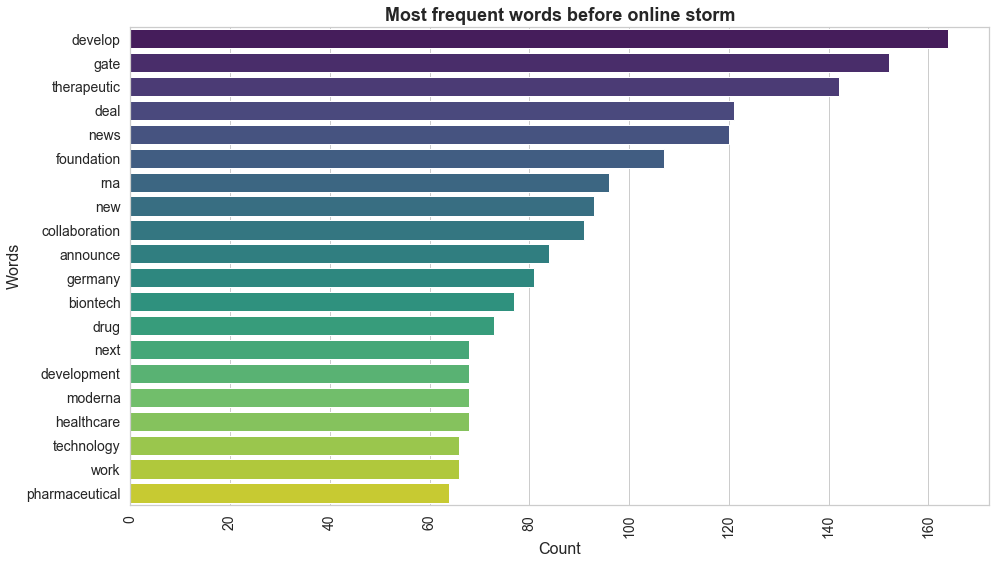

In [156]:
# plot word frequency before online storm
word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'viridis',
       'title': 'Most frequent words before online storm',
       'fname':'word_frequency_before_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

['bill melinda gate ', 46]
['melinda gate foundation ', 40]
['develop next generation ', 32]
['pharmaceutical healthcare deal ', 31]
['healthcare deal alliance ', 31]
['deal alliance profile ', 31]
['next generation lung ', 24]
['moderna_tx biontech beascientist ', 22]
['announce collaboration develop ', 21]
['broad strategic collaboration ', 21]


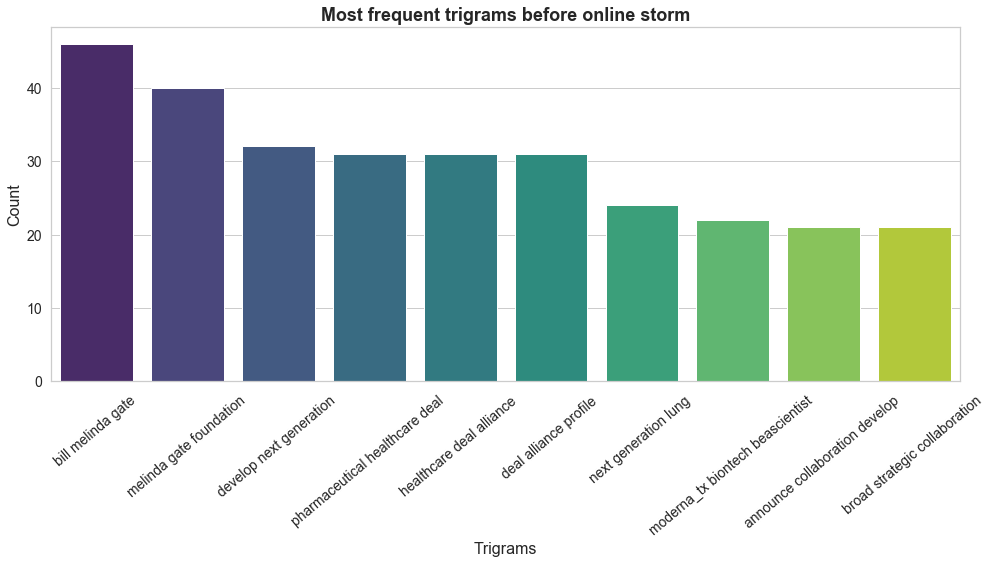

In [157]:
# plot trigram frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'viridis',
       'title': 'Most frequent trigrams before online storm',
       'fname':'trigrams_frequency_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

<Figure size 432x288 with 0 Axes>

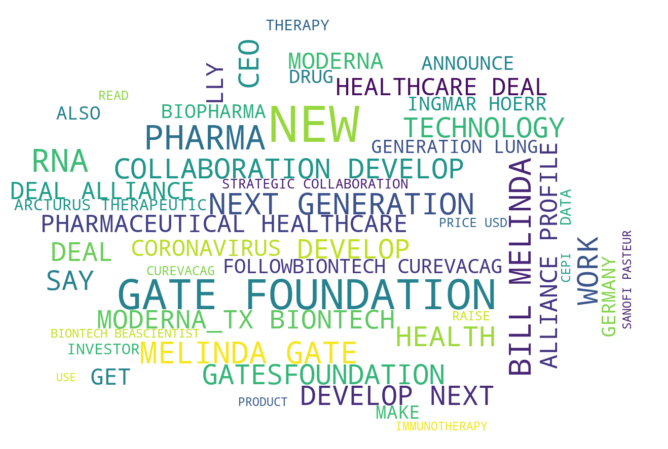

In [158]:
display_wordcloud(tokens)

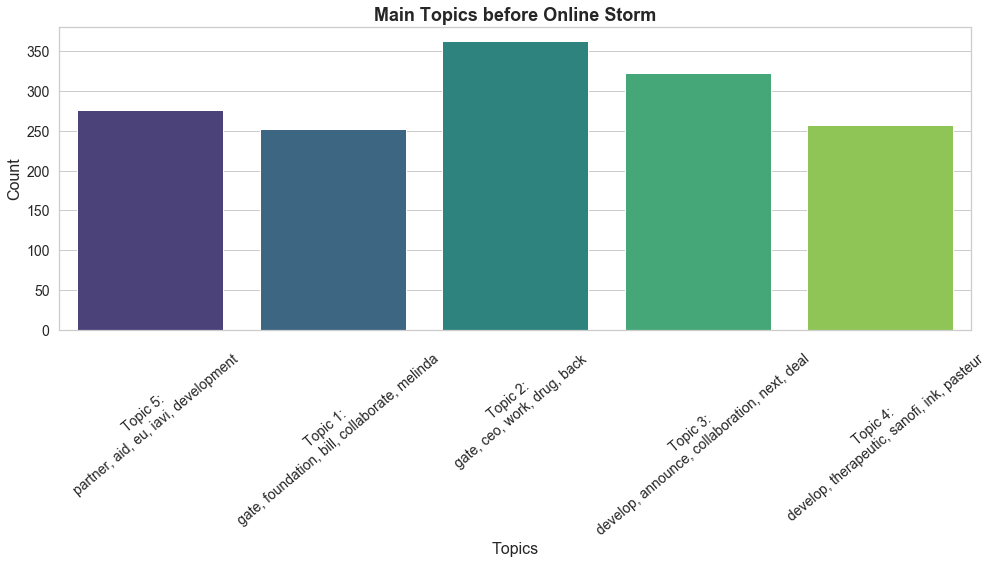

In [159]:
# LDA topics
df_topics = get_topics(df['edited'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'viridis',
       'title': 'Main Topics before Online Storm',
       'fname':'LDA_Topics_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

## During the online storm

In [160]:
df =tweets[tweets['onlinestorm']]

In [161]:
# Merging all the requests into a single line
text_merged = ''
for line in df['edited']:
    text_merged = text_merged + ' ' + line
    
# get tokens and trigrams
tokens = text_merged.split(' ')
trigrams = nltk.trigrams(tokens)


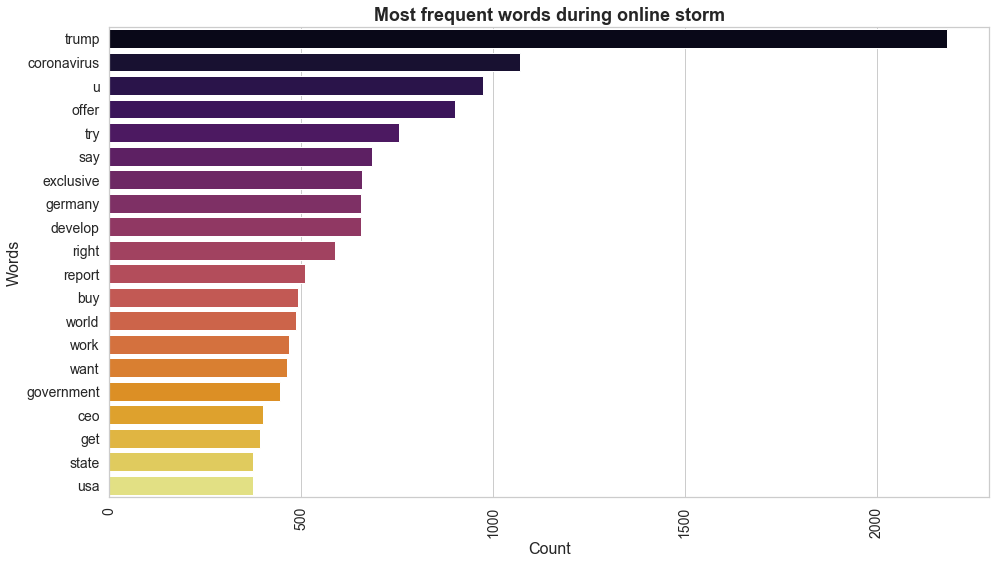

In [162]:
# plot word frequency during online storm
word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'inferno',
       'title': 'Most frequent words during online storm',
       'fname':'word_frequency_during_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

['large sum money ', 175]
['offer large sum ', 172]
['president donald trump ', 108]
['develop whole world ', 106]
['trump offer large ', 97]
['trump try buy ', 96]
['health ministry confirm ', 88]
['newspaper welt sonntag ', 87]
['report trump offer ', 85]
['trump try get ', 82]


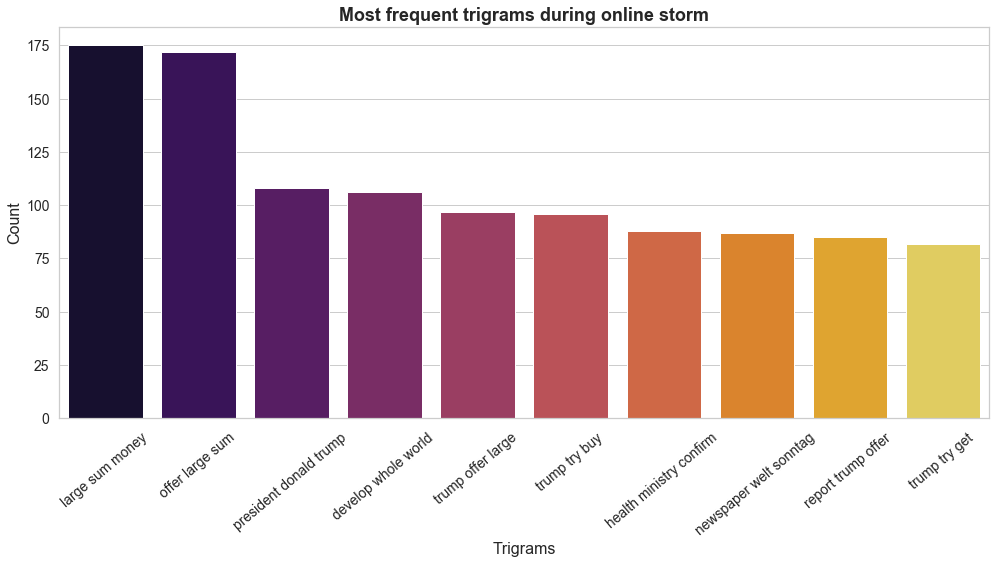

In [163]:
# plot trigrams frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'inferno',
       'title': 'Most frequent trigrams during online storm',
       'fname':'trigrams_frequency_during_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

<Figure size 432x288 with 0 Axes>

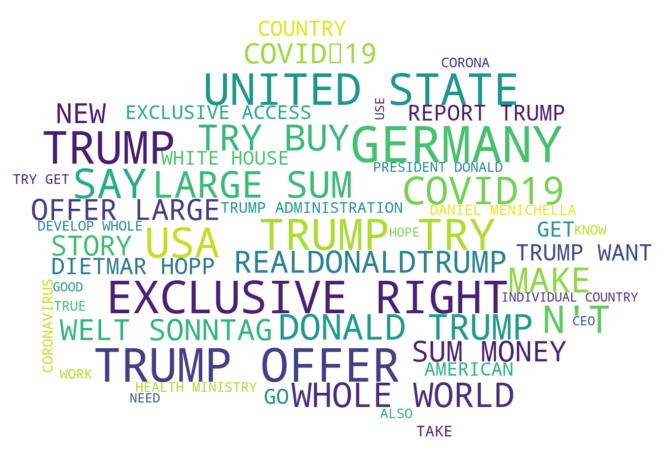

In [164]:
display_wordcloud(tokens)

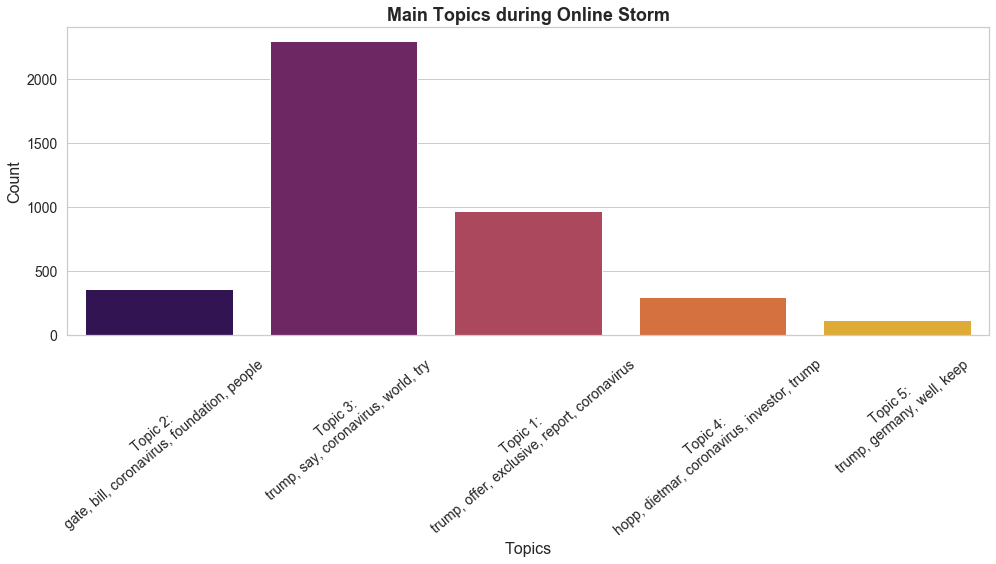

In [165]:
# LDA topics
df_topics = get_topics(df['edited'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'inferno',
       'title': 'Main Topics during Online Storm',
       'fname':'LDA_Topics_during_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

## Step 5: EMOTIONS ANALYSIS

In [166]:
import termcolor
import sys
from termcolor import colored, cprint
plt.style.use('fivethirtyeight')

In [167]:
ncr = pd.read_csv('../input/NCR-lexicon.csv', sep =';')

In [168]:
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

In [169]:
# Merging all the requests into a single line
all_text = ''
for line in tweets['edited']:
    all_text = all_text + ' ' + line
    
# get tokens and trigrams
tokens = all_text.split(' ')

# Criam-se agora, a partir das palavras únicas, os dicionários de índices para referência futura
unique_words = set(tokens)
word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
ind_to_word = dict((i, word) for i, word in enumerate(unique_words))

In [170]:
def plot_emotions_period(df, cols, period = 'h' ):

    df1 = df.groupby(df['datetime'].dt.to_period(period)).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, cols)

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3,dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title('Emotions in Tweets with CureVac', fontsize=20)
    plt.xlabel('15 March', fontsize=15)
    plt.ylabel('Average Emotions', fontsize=15)
    plt.savefig('../images/Emotions_during_onlinestorm.png')       
    return

In [171]:
def get_tweet_emotions(df, emotions, col):

    df_base = df.copy()
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    

    list_emotion_counts = []

    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    #criamos um dataframe de zeros com a dimensão de df
    df_emotions = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    x = 0
    for i, row in df_base.iterrows():
        tweet = word_tokenize(df_base.loc[i][col])
        for word in tweet:
            word_stemmed = stemmer.stem(word.lower())
            result = ncr[ncr.English == word_stemmed]
            if not result.empty:
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                                       
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                        except:
                            continue
                                
    df_base = pd.concat([df_base, df_emotions], axis=1)

    return df_base, list_emotion_counts

In [172]:
    
def get_top_emotion_words(word_counts, n = 5):

    # Passamos finalmente o dicionário para uma numpy array "words", com o indice da palavra e respectiva frequência
    words = np.zeros((len(word_counts), 2), dtype=int)
    for i, w in enumerate(word_counts):
        words[i][0] = w
        words[i][1] = word_counts[w]

    # A partir dos indices gerados pela função argsort, sabemos a posição 
    # das "n" palavras mais frequentes na array words
    top_words_indices = np.flip(np.argsort(words[:,1])[-n:],0)

    # Com estas posições (indices), obtemos os indices que funcionam como keys no dicionário ind_to_word,
    # e nos devolvem, como "value", as palavras como strings
    top_words = [words[ind][0] for ind in top_words_indices]
        
    return words, top_words, top_words_indices

In [173]:
# Criação de uma dataframe de tweets associados a emoções
# A execução pode ser longa, dependendo do tamanho da amostra de tweets

df_emo, list_emotion_counts = get_tweet_emotions(tweets, emotions, 'edited')

df_emo['datetime']= pd.to_datetime(df_emo['datetime']) 


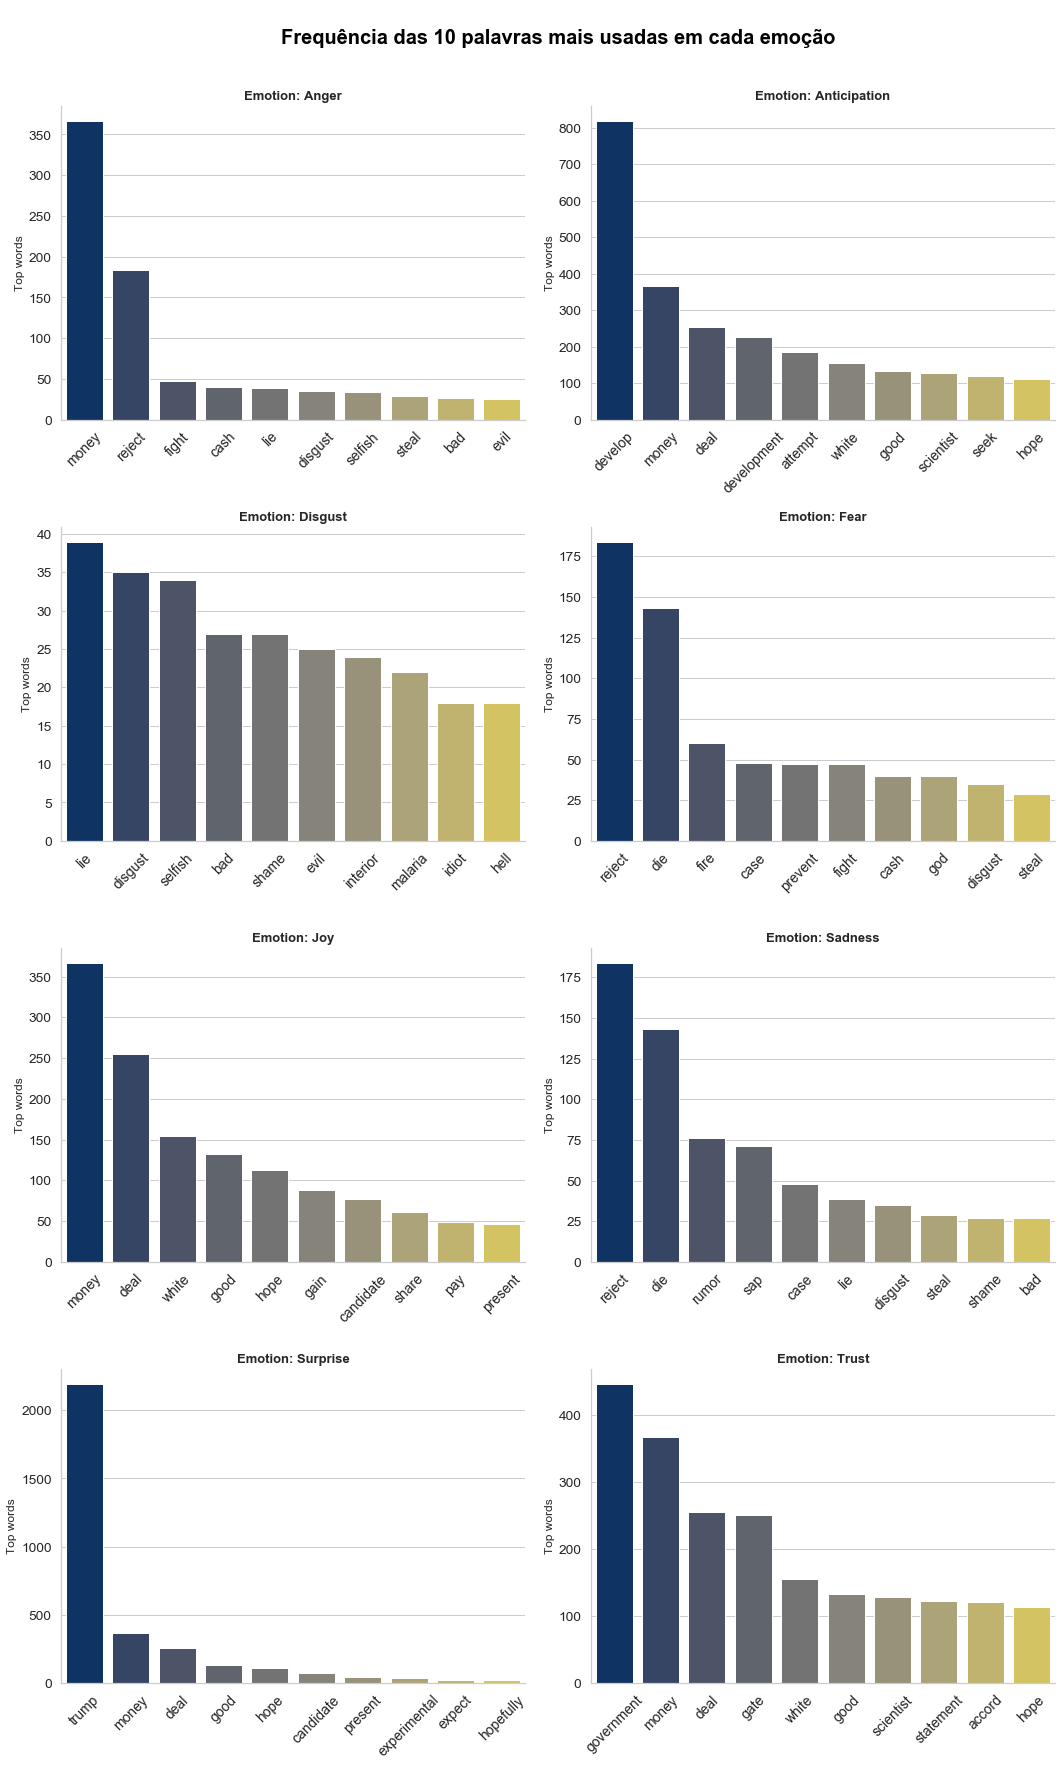

In [83]:
###############################################################################
# Mostra distribuição das 10 palavras mais frequentes em cada emoção
############################################################################### 

fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for i, emotion in enumerate(emotions): # para cada emoção ...

    # Para esta emoção, cria um dicionário com as 10 palavras mais frequentes
    words, top_words, top_words_indices = get_top_emotion_words(list_emotion_counts[i]['emo_frq'], 10)
    dados = {'valores' : [words[ind][1] for ind in top_words_indices], 
                      'labels' : [ind_to_word[word] for word in top_words]}
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(4, 2, counter+1) # faz 4 gráficos por linha
    sns.despine()
    ax = sns.barplot(x='labels', y='valores', data=dados, palette=("cividis"))
    plt.ylabel('Top words', fontsize=12)
    ax.set_title(label=str('Emotion: ') + emotion, fontweight='bold', size=13)
    plt.xticks(rotation=45, fontsize=14)
    counter += 1

axs.set_title(label='\nFrequência das 10 palavras mais usadas em cada emoção\n', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
plt.savefig('../images/Top10_palavras_em_cada_emocao.png')

### Filter for March 2020

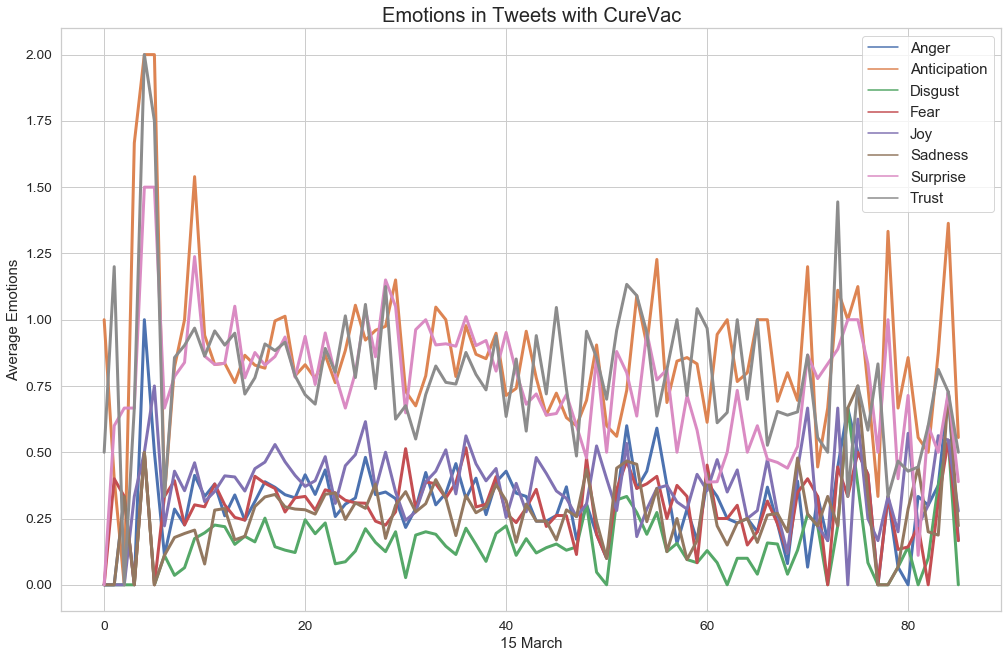

In [84]:
plot_emotions_period(df_emo[df_emo['onlinestorm']], emotions)

In [85]:
df_emo['neg_emotions'] = df_emo['Sadness'] + df_emo['Fear'] + df_emo['Disgust'] + df_emo['Anger']
df_emo['pos_emotions'] = df_emo['Joy'] + df_emo['Anticipation'] + df_emo['Trust']

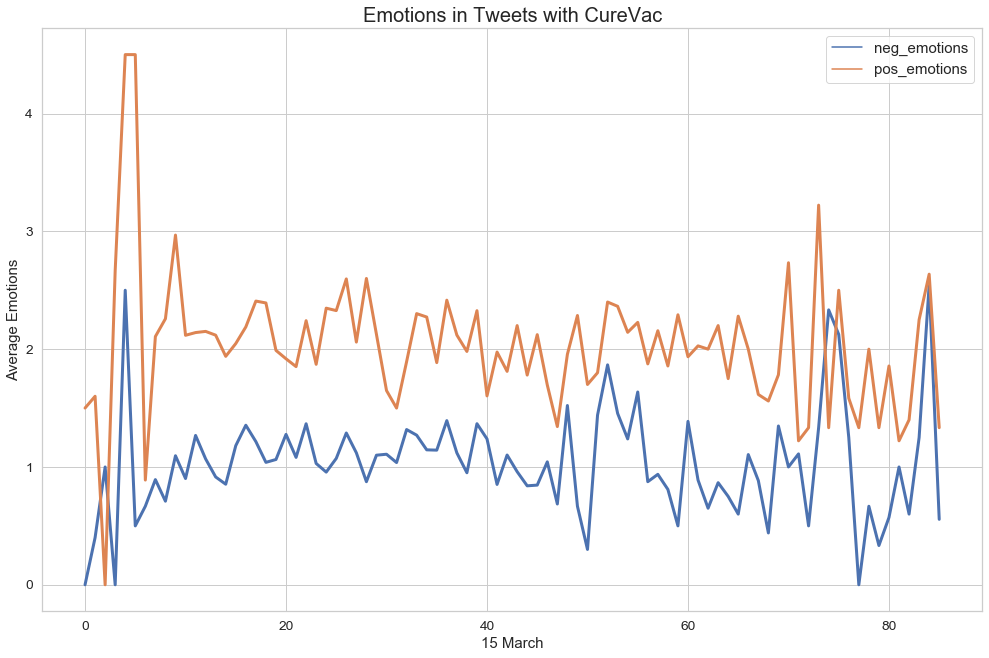

In [86]:
plot_emotions_period(df_emo[df_emo['onlinestorm']], ['neg_emotions', 'pos_emotions'])

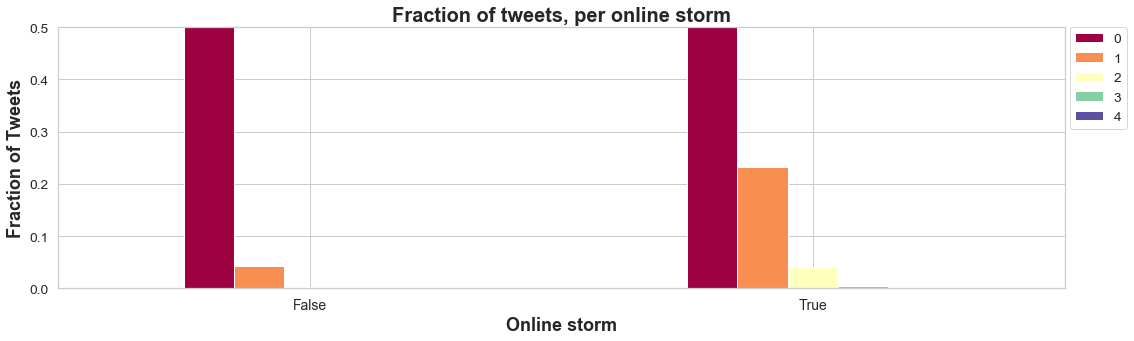

In [87]:
props = df_emo.groupby('onlinestorm')['Anger'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Online storm', fontweight='bold', fontsize=18)
plt.xticks(rotation=0,fontsize=14)
plt.ylim(0, 0.5)
plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
plt1.set_title(label='Fraction of tweets, per online storm', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('../images/percentage_tweets_vs_online_storm.png')

In [88]:
df_emo['total_neg_emotions'] = df_emo['neg_emotions'].apply(lambda x: x > 0)

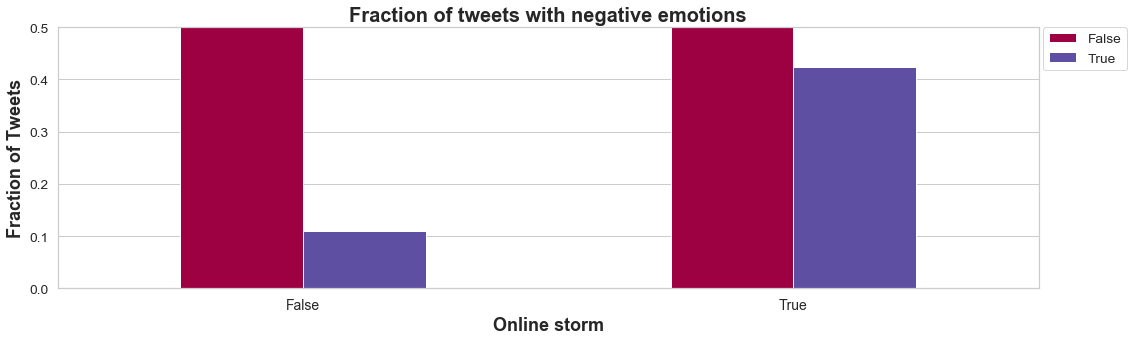

In [89]:
props = df_emo.groupby('onlinestorm')['total_neg_emotions'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Online storm', fontweight='bold', fontsize=18)
plt.xticks(rotation=0,fontsize=14)
plt.ylim(0, 0.5)
plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
plt1.set_title(label='Fraction of tweets with negative emotions', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('../images/percentage_tweets_vs_online_storm.png')

In [90]:
def get_words(word_list, emotions):
    
    words_emotion_idx = []
    
    for i, word in enumerate(word_list):
        word = stemmer.stem(word.lower())
        result = ncr[ncr.English == word]
        if not result.empty:
            for emotion in emotions:
                if result[emotion].any() > 0:
                    words_emotion_idx.append(i)
                
    return words_emotion_idx

In [91]:
def print_colored_emotions(tweets, emotions, color, on_color):
    
    for tweet in tweets:

        word_list = word_tokenize(tweet)

        word_emotion_idx = get_words(word_list, emotions)

        for i, w in enumerate(word_list):
            if i in word_emotion_idx:
                w=colored(w, color=color, on_color=on_color)
            print(w, end='') 
            print(' ', end='')  

        print('\n')

        
    return

In [92]:
df = df_emo[df_emo['Sadness'] > 3]
print_colored_emotions(df['text'], ['Disgust','Sadness','Anger','Fear'], 'white', 'on_red')

Die Stiftung von Bill Gates investiert 52 Millionen Dollar in dt . Firma CureVac , die an Impfstoff gegen # Coronavirus forscht . ( Das ist die Firma , an der die US-Regierung großes Interesse hat aktuell , siehe : https : // twitter.com/AscotBlack/sta tus/1239161218398670848 ? s=19 … ) https : //www . forbes.com/sites/matthewh erper/2015/03/05/bill-melinda-gates-foundation-makes-largest-ever-equity-investment-in-a-biotech-company/amp/ ? __twitter_impression=truehttps : //www.forbes.com/sites/matthewherper/2015/03/05/bill-melinda-gates-foundation-makes-largest-ever-equity-investment-in-a-biotech-company/amp/ ? __twitter_impression=true … 

You created crowded conditions @ airports corralling sick w/healthy . This will lead to further disease spreading . Your denials & delays , along w/ill-prepared quarter measures are going to kill many . And stop trying to steal CureVac for U.S. only . # VaccinesForAll 

@ KimStrassel @ kimguilfoyle @ seanmdav @ maggieNYT That wasn ’ t the lie put for

In [93]:
df = df_emo[df_emo['Anticipation'] > 4]
print_colored_emotions(df['text'], ['Joy','Trust','Anticipation'], 'white', 'on_green')

UK pharma is equally likely to develop a vaccine . In fact , pharma all over the world are searching for a vaccine for SARS-CoV-2 . CureVac is unlikely to develop one quickly enough alone . Now 's a good time for pharma to cooperate , rather than compete for financial gains . 

It works ! It worked after 9/11 . God Bless Lee Greenwood ! God Bless CureVac ! God Bless China ! God Bless Italy ! God Bless Iran ! God Bless South Korea ! God Bless Germany Too ! God Bless Asia , Europe , Africa , Americas & Australia . pic.twitter.com/dSKwPrLTeD 

Glad researchers behind GER lab # CureVac have '' vetoed '' this , it s a sign of huge progress from the times of # WorldWar . Einstein & others gave up their research to build d A-Bomb : if we do give up our values to money we have nothing else but # death ahead . # EU stay strong @ vonderleyen 

Take Precautions . Pray Harder . Pray that something good comes out of ' Curevac among others . Faith over Fear . This too shall pass in JESUS name . Once